# Deploy a model as an online endpoint- Outer Loop

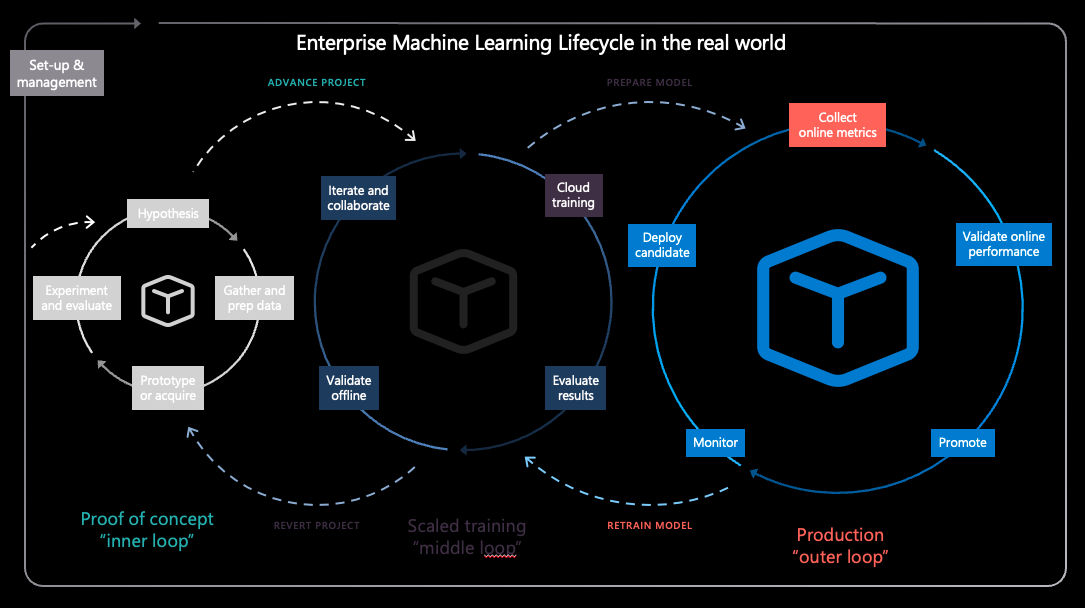

Learn to deploy a model to an online endpoint, using Azure Machine Learning Python SDK v2.

In this tutorial, we use a model trained to predict the likelihood of defaulting on a credit card payment. The goal is to deploy this model and show its use.

The steps you'll take are:

> * Register your model
> * Create an endpoint and a first deployment
> * Deploy a trial run
> * Manually send test data to the deployment
> * Get details of the deployment
> * Create a second deployment
> * Manually scale the second deployment
> * Update allocation of production traffic between both deployments
> * Get details of the second deployment
> * Roll out the new deployment and delete the first one

## Create handle to workspace

Before we dive in the code, you need a way to reference your workspace. You'll create `ml_client` for a handle to the workspace.  You'll then use `ml_client` to manage resources and jobs.

In the next cell, enter your Subscription ID, Resource Group name and Workspace name. To find these values:

1. In the upper right Azure Machine Learning studio toolbar, select your workspace name.
1. Copy the value for workspace, resource group and subscription ID into the code.
1. You'll need to copy one value, close the area and paste, then come back for the next one.

## Load local environment

For the purposes of this tutorial, environment variables used during the exercise are stored in a .env file.  Please create or modify your local .env file prior to the next steps.

(Optional) If not already installed, install environment management package

In [ ]:
!conda install python-dotenv

### Set environment variable values

- Step 1: Copy the provided .env.sample and rename it to .env
- Step 2: Set the variables in the newly created .env file to your account-specific values
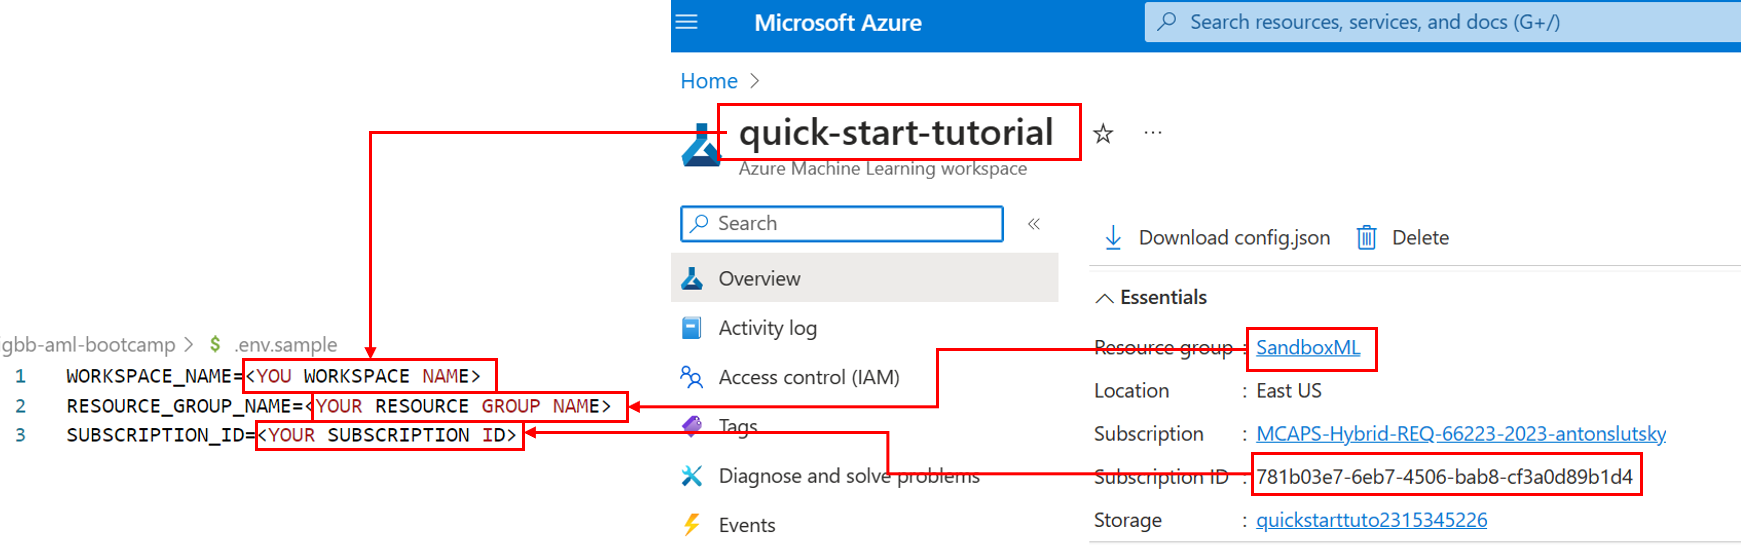
- Step 3: Proceed to the next step 

Load local environment from the .env file

In [1]:
%reload_ext dotenv
%dotenv

##### Configure Azure ML session

It is now necessary to configure local Azure ML session to point to the appropriate workspace and resource group.  The following code configures local CLI environment for subsequent use.

In [3]:
import platform 
current_platform = platform.system()
if "Windows" == current_platform:
    !az configure --defaults workspace=%WORKSPACE_NAME% group=%RESOURCE_GROUP_NAME%
else:
    !az configure --defaults workspace=$WORKSPACE_NAME group=$RESOURCE_GROUP_NAME

==========================================================================================
# OPTIONAL- Run this if you have not done previous steps!

## Register the model

If you already completed the earlier training tutorial,  [Train a model](https://learn.microsoft.com/en-us/azure/machine-learning/tutorial-train-model), you've registered an MLflow model as part of the training script and can skip to the next section. 

If you didn't complete the training tutorial, you'll need to register the model. Registering your model before deployment is a recommended best practice.

In this example, we specify the `path` (where to upload files from) inline. If you [cloned the tutorials folder](https://learn.microsoft.com/en-us/azure/machine-learning/quickstart-create-resources##learn-from-sample-notebooks), then run the following code as-is. Otherwise, [download the files and metadata for the model to deploy](https://azuremlexampledata.blob.core.windows.net/datasets/credit_defaults_model.zip). Update the path to the location on your local computer where you've unzipped the model's files. 

The SDK automatically uploads the files and registers the model. 

For more information on registering your model as an asset, see [Register your model as an asset in Machine Learning by using the SDK](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-manage-models?tabs=use-local%2Ccli#register-your-model-as-an-asset-in-machine-learning-by-using-the-sdk).

In [96]:
%%writefile register_model.yml
$schema: https://azuremlschemas.azureedge.net/latest/model.schema.json
name: credit_defaults_model
path: ./deploy/credit_defaults_model/
type: mlflow_model
description: Credit Defaults Model.

Overwriting register_model.yml


In [97]:
!az ml model create -f register_model.yml

{
  "creation_context": {
    "created_at": "2023-10-19T13:16:52.304982+00:00",
    "created_by": "Anton Slutsky",
    "created_by_type": "User",
    "last_modified_at": "2023-10-19T13:16:52.304982+00:00",
    "last_modified_by": "Anton Slutsky",
    "last_modified_by_type": "User"
  },
  "description": "Credit Defaults Model.",
  "flavors": {
    "python_function": {
      "env": "conda.yaml",
      "loader_module": "mlflow.sklearn",
      "model_path": "model.pkl",
      "python_version": "3.8.15"
    },
    "sklearn": {
      "code": "",
      "pickled_model": "model.pkl",
      "serialization_format": "cloudpickle",
      "sklearn_version": "0.24.2"
    }
  },
  "id": "azureml:/subscriptions/781b03e7-6eb7-4506-bab8-cf3a0d89b1d4/resourceGroups/SandboxML/providers/Microsoft.MachineLearningServices/workspaces/quick-start-tutorial/models/credit_defaults_model/versions/7",
  "name": "credit_defaults_model",
  "path": "azureml://subscriptions/781b03e7-6eb7-4506-bab8-cf3a0d89b1d4/resource

## Confirm that the model is registered

You can check the **Models** page in [Azure Machine Learning studio](https://ml.azure.com/) to identify the latest version of your registered model.

![View model](./media/registered-model-in-studio.png)

Alternatively, the code below will retrieve the relevant version number for you to use.

In [102]:
!az ml model list --name credit_defaults_model 

[
  {
    "creation_context": {
      "created_at": "2023-10-19T13:16:52.304982+00:00",
      "created_by": "Anton Slutsky",
      "created_by_type": "User",
      "last_modified_at": "2023-10-19T13:16:52.304982+00:00",
      "last_modified_by": "Anton Slutsky",
      "last_modified_by_type": "User"
    },
    "description": "Credit Defaults Model.",
    "id": "azureml:/subscriptions/781b03e7-6eb7-4506-bab8-cf3a0d89b1d4/resourceGroups/SandboxML/providers/Microsoft.MachineLearningServices/workspaces/quick-start-tutorial/models/credit_defaults_model/versions/7",
    "model type": "mlflow_model",
    "name": "credit_defaults_model",
    "path": "azureml://subscriptions/781b03e7-6eb7-4506-bab8-cf3a0d89b1d4/resourceGroups/SandboxML/workspaces/quick-start-tutorial/datastores/workspaceblobstore/paths/LocalUpload/3480a1d0fce39f773f618d313d2687ca/credit_defaults_model",
    "properties": {},
    "resourceGroup": "SandboxML",
    "stage": "Development",
    "tags": {},
    "version": "7"
  },
  

Now that you have a registered model, you can create an endpoint and deployment. The next section will briefly cover some key details about these topics.

## Endpoints and deployments

After you train a machine learning model, you need to deploy it so that others can use it for inferencing. For this purpose, Azure Machine Learning allows you to create **endpoints** and add **deployments** to them.

An **endpoint**, in this context, is an HTTPS path that provides an interface for clients to send requests (input data) to a trained model and receive the inferencing (scoring) results back from the model. An endpoint provides:

- Authentication using "key or token" based auth 
- [TLS(SSL)](https://simple.wikipedia.org/wiki/Transport_Layer_Security) termination
- A stable scoring URI (endpoint-name.region.inference.ml.azure.com)


A **deployment** is a set of resources required for hosting the model that does the actual inferencing. 

A single endpoint can contain multiple deployments. Endpoints and deployments are independent Azure Resource Manager resources that appear in the Azure portal.

Azure Machine Learning allows you to implement [online endpoints](https://learn.microsoft.com/en-us/azure/machine-learning/concept-endpoints#what-are-online-endpoints) for real-time inferencing on client data, and [batch endpoints](https://learn.microsoft.com/en-us/azure/machine-learning/concept-endpoints#what-are-batch-endpoints) for inferencing on large volumes of data over a period of time. 

In this tutorial, we'll walk you through the steps of implementing a _managed online endpoint_. Managed online endpoints work with powerful CPU and GPU machines in Azure in a scalable, fully managed way that frees you from the overhead of setting up and managing the underlying deployment infrastructure.

## Create an online endpoint

Now that you have a registered model, it's time to create your online endpoint. The endpoint name needs to be unique in the entire Azure region. For this tutorial, you'll create a unique name using a universally unique identifier [`UUID`](https://en.wikipedia.org/wiki/Universally_unique_identifier). For more information on the endpoint naming rules, see [managed online endpoint limits](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-manage-quotas#azure-machine-learning-managed-online-endpoints).

In [7]:
%%writefile endpoint.yml
$schema: https://azuremlschemas.azureedge.net/latest/managedOnlineEndpoint.schema.json
name: credit-endpoint-3
auth_mode: key
tags:
    training_dataset : credit_defaults

Overwriting endpoint.yml


First, we'll define the endpoint, using the `ManagedOnlineEndpoint` class.



> [!TIP]
> * `auth_mode` : Use `key` for key-based authentication. Use `aml_token` for Azure Machine Learning token-based authentication. A `key` doesn't expire, but `aml_token` does expire. For more information on authenticating, see [Authenticate to an online endpoint](https://learn.microsoft.com/azure/machine-learning/how-to-authenticate-online-endpoint).
> * Optionally, you can add a description and tags to your endpoint.

In [8]:
!az ml online-endpoint create --file endpoint.yml

{
  "auth_mode": "key",
  "id": "/subscriptions/781b03e7-6eb7-4506-bab8-cf3a0d89b1d4/resourceGroups/SandboxML/providers/Microsoft.MachineLearningServices/workspaces/quick-start-tutorial/onlineEndpoints/credit-endpoint-3",
  "identity": {
    "principal_id": "ce19598f-064a-4be5-8d8c-c38f5cc1e4b8",
    "tenant_id": "16b3c013-d300-468d-ac64-7eda0820b6d3",
    "type": "system_assigned"
  },
  "kind": "Managed",
  "location": "eastus",
  "mirror_traffic": {},
  "name": "credit-endpoint-3",
  "openapi_uri": "https://credit-endpoint-3.eastus.inference.ml.azure.com/swagger.json",
  "properties": {
    "AzureAsyncOperationUri": "https://management.azure.com/subscriptions/781b03e7-6eb7-4506-bab8-cf3a0d89b1d4/providers/Microsoft.MachineLearningServices/locations/eastus/mfeOperationsStatus/oe:228a5faf-b108-49f1-aca6-2709336183e6:426996c5-64a3-44ef-91a4-0ff6ee13c91d?api-version=2022-02-01-preview",
    "azureml.onlineendpointid": "/subscriptions/781b03e7-6eb7-4506-bab8-cf3a0d89b1d4/resourcegroups/s

Using the `MLClient` created earlier, we'll now create the endpoint in the workspace. This command will start the endpoint creation and return a confirmation response while the endpoint creation continues.

> [!NOTE]
> Expect the endpoint creation to take approximately 2 minutes.

## Understanding online deployments

The key aspects of a deployment include:

- `name` - Name of the deployment.
- `endpoint_name` - Name of the endpoint that will contain the deployment.
- `model` - The model to use for the deployment. This value can be either a reference to an existing versioned model in the workspace or an inline model specification.
- `environment` - The environment to use for the deployment (or to run the model). This value can be either a reference to an existing versioned environment in the workspace or an inline environment specification. The environment can be a Docker image with Conda dependencies or a Dockerfile.
- `code_configuration` - the configuration for the source code and scoring script.
    - `path`- Path to the source code directory for scoring the model.
    - `scoring_script` - Relative path to the scoring file in the source code directory. This script executes the model on a given input request. For an example of a scoring script, see [Understand the scoring script](https://learn.microsoft.com/azure/machine-learning/how-to-deploy-online-endpoints#understand-the-scoring-script) in the "Deploy an ML model with an online endpoint" article.
- `instance_type` - The VM size to use for the deployment. For the list of supported sizes, see [Managed online endpoints SKU list](https://learn.microsoft.com/azure/machine-learning/reference-managed-online-endpoints-vm-sku-list).
- `instance_count` - The number of instances to use for the deployment.
    
### Deployment using an MLflow model

Azure Machine Learning supports no-code deployment of a model created and logged with MLflow. This means that you don't have to provide a scoring script or an environment during model deployment, as the scoring script and environment are automatically generated when training an MLflow model. If you were using a custom model, though, you'd have to specify the environment and scoring script during deployment.

> [!IMPORTANT]
> If you typically deploy models using scoring scripts and custom environments and want to achieve the same functionality using MLflow models, we recommend reading [Using MLflow models for no-code deployment](https://learn.microsoft.com/azure/machine-learning/how-to-deploy-mlflow-models).

## Deploy the model to the endpoint

You'll begin by creating a single deployment that handles 100% of the incoming traffic. We've chosen an arbitrary color name (*blue*) for the deployment. To create the deployment for our endpoint, we'll use the `ManagedOnlineDeployment` class.

> [!NOTE]
> No need to specify an environment or scoring script as the model to deploy is an MLflow model.

In [117]:
!az ml model download --name credit_defaults_model --version 11 --download-path .

In [34]:
%%writefile deployment.yml
$schema: https://azuremlschemas.azureedge.net/latest/managedOnlineDeployment.schema.json
name: orange
endpoint_name: credit-endpoint-3
model: 
    name: credit_defaults_model
    path: credit_defaults_model/credit_defaults_model
    type: mlflow_model
environment: azureml:credit-card-scikit-38:9
code_configuration:
  code: src
  scoring_script: score.py
instance_type: Standard_DS3_v2
instance_count: 1

Overwriting deployment.yml


Using the `online-deployment` command, we'll now create the deployment in the workspace. This command will start the deployment creation and return a confirmation response while the deployment creation continues.

In [35]:
!az ml online-deployment create --file deployment.yml --skip-script-validation --all-traffic

...............................................................................................................................................................................................................................................


All traffic will be set to deployment orange once it has been provisioned.
If you interrupt this command or it times out while waiting for the provisioning, you can try to set all the traffic to this deployment later once its has been provisioned.
Check: endpoint credit-endpoint-3 exists
ERROR: (None) ResourceNotFound: Deployment failed due to timeout while waiting for Environment Image to become available. Check Environment Build Log in ML Studio Workspace or Workspace storage for potential failures. Image build summary: [N/A]. Environment info: Name: credit-card-scikit-38, Version: 9. Please see troubleshooting guide, available here: https://aka.ms/oe-tsg#error-resourcenotfound
Code: None
Message: ResourceNotFound: Deployment failed due to timeout while waiting for Environment Image to become available. Check Environment Build Log in ML Studio Workspace or Workspace storage for potential failures. Image build summary: [N/A]. Environment info: Name: credit-card-scikit-38, Version: 9. 

## Check the status of the endpoint
You can check the status of the endpoint to see whether the model was deployed without error:

In [36]:
!az ml online-deployment show --name blue --endpoint-name credit-endpoint-3

{
  "app_insights_enabled": false,
  "code_configuration": {
    "code": "/subscriptions/781b03e7-6eb7-4506-bab8-cf3a0d89b1d4/resourceGroups/SandboxML/providers/Microsoft.MachineLearningServices/workspaces/quick-start-tutorial/codes/466d72f9-0c55-4752-b654-cc675953c8b3/versions/1",
    "scoring_script": "score.py"
  },
  "egress_public_network_access": "enabled",
  "endpoint_name": "credit-endpoint-3",
  "environment": "azureml:/subscriptions/781b03e7-6eb7-4506-bab8-cf3a0d89b1d4/resourceGroups/SandboxML/providers/Microsoft.MachineLearningServices/workspaces/quick-start-tutorial/environments/credit-card-scikit-38/versions/8",
  "environment_variables": {},
  "id": "/subscriptions/781b03e7-6eb7-4506-bab8-cf3a0d89b1d4/resourceGroups/SandboxML/providers/Microsoft.MachineLearningServices/workspaces/quick-start-tutorial/onlineEndpoints/credit-endpoint-3/deployments/blue",
  "instance_count": 1,
  "instance_type": "Standard_DS3_v2",
  "liveness_probe": {
    "failure_threshold": 30,
    "init

## Test the endpoint with sample data

Now that the model is deployed to the endpoint, you can run inference with it. Let's create a sample request file following the design expected in the run method in the scoring script.

Now, create the file in the deploy directory. The cell below uses IPython magic to write the file into the directory you just created.

Using the `MLClient` created earlier, we'll get a handle to the endpoint. The endpoint can be invoked using the `invoke` command with the following parameters:

* `endpoint_name` - Name of the endpoint
* `request_file` - File with request data
* `deployment_name` - Name of the specific deployment to test in an endpoint

We'll test the blue deployment with the sample data.

In [39]:
%%writefile sample-request.json
{
  "input_data": {
    "columns": [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22],
    "index": [0, 1],
    "data": [
            [20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0],
            [10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 10, 9, 8]
            ]
                }
}

Overwriting sample-request.json


In [41]:
!az ml online-endpoint invoke --name credit-endpoint-3 --request-file sample-request.json --deployment-name blue

ERROR: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


## Get logs of the deployment
Check the logs to see whether the endpoint/deployment were invoked successfully
If you face errors, see [Troubleshooting online endpoints deployment](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-troubleshoot-online-endpoints?tabs=cli).

In [44]:
!az ml online-deployment get-logs --name blue --endpoint-name credit-endpoint-3 --lines 50

Instance status:
SystemSetup: Succeeded
UserContainerImagePull: Succeeded
ModelDownload: Succeeded
UserContainerStart: InProgress

Container events:
Kind: Pod, Name: Downloading, Type: Normal, Time: 2023-10-19T15:44:37.677505Z, Message: Start downloading models
Kind: Pod, Name: Pulling, Type: Normal, Time: 2023-10-19T15:44:37.868721Z, Message: Start pulling container image
Kind: Pod, Name: Pulled, Type: Normal, Time: 2023-10-19T15:45:35.266085Z, Message: Container image is pulled successfully
Kind: Pod, Name: Downloaded, Type: Normal, Time: 2023-10-19T15:45:35.266085Z, Message: Models are downloaded successfully
Kind: Pod, Name: Created, Type: Normal, Time: 2023-10-19T15:45:35.338775Z, Message: Created container inference-server
Kind: Pod, Name: Started, Type: Normal, Time: 2023-10-19T15:45:35.404662Z, Message: Started container inference-server

Container logs:

Server Routes
---------------
Liveness Probe: GET   127.0.0.1:31311/
Score:          POST  127.0.0.1:31311/score

Starting g

## Create a second deployment 
Deploy the model as a second deployment called `green`. In practice, you can create several deployments and compare their performance. These deployments could use a different version of the same model, a completely different model, or a more powerful compute instance. In our example, you'll deploy the same model version using a more powerful compute instance that could potentially improve performance.

In [45]:
%%writefile deployment.yml
$schema: https://azuremlschemas.azureedge.net/latest/managedOnlineDeployment.schema.json
name: green
endpoint_name: credit-endpoint-3
model: 
    name: credit_defaults_model
    path: credit_defaults_model/credit_defaults_model
    type: mlflow_model
environment: azureml:credit-card-scikit-38:9
code_configuration:
  code: src
  scoring_script: score.py
instance_type: Standard_DS3_v2
instance_count: 1

Overwriting deployment.yml


In [ ]:
!az ml online-deployment create --file deployment.yml --skip-script-validation --all-traffic

...............................................................................................................................................................................................................................................


All traffic will be set to deployment orange once it has been provisioned.
If you interrupt this command or it times out while waiting for the provisioning, you can try to set all the traffic to this deployment later once its has been provisioned.
Check: endpoint credit-endpoint-3 exists
ERROR: (None) ResourceNotFound: Deployment failed due to timeout while waiting for Environment Image to become available. Check Environment Build Log in ML Studio Workspace or Workspace storage for potential failures. Image build summary: [N/A]. Environment info: Name: credit-card-scikit-38, Version: 9. Please see troubleshooting guide, available here: https://aka.ms/oe-tsg#error-resourcenotfound
Code: None
Message: ResourceNotFound: Deployment failed due to timeout while waiting for Environment Image to become available. Check Environment Build Log in ML Studio Workspace or Workspace storage for potential failures. Image build summary: [N/A]. Environment info: Name: credit-card-scikit-38, Version: 9. 

## Scale deployment to handle more traffic

Using the `MLClient` created earlier, we'll get a handle to the `green` deployment. The deployment can be scaled by increasing or decreasing the `instance_count`.

In the following code, you'll increase the VM instance manually. However, note that it is also possible to autoscale online endpoints. Autoscale automatically runs the right amount of resources to handle the load on your application. Managed online endpoints support autoscaling through integration with the Azure monitor autoscale feature. To configure autoscaling, see [autoscale online endpoints](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-autoscale-endpoints?tabs=python).

In [47]:
%%writefile deployment_2.yml
$schema: https://azuremlschemas.azureedge.net/latest/managedOnlineDeployment.schema.json
name: green
endpoint_name: credit-endpoint-3
model: 
    name: credit_defaults_model
    path: credit_defaults_model/credit_defaults_model
    type: mlflow_model
environment: azureml:credit-card-scikit-38:9
code_configuration:
  code: src
  scoring_script: score.py
instance_type: Standard_DS3_v2
instance_count: 2

Writing deployment_2.yml


In [49]:
!az ml online-deployment update --file deployment_2.yml

^C


## Update traffic allocation for deployments
You can split production traffic between deployments. You may first want to test the `green` deployment with sample data, just like you did for the `blue` deployment. Once you've tested your green deployment, allocate a small percentage of traffic to it.

In [51]:
%%writefile endpoint_2.yml
$schema: https://azuremlschemas.azureedge.net/latest/managedOnlineEndpoint.schema.json
name: credit-endpoint-3
auth_mode: key
tags:
    training_dataset : credit_defaults
traffic:
    blue: 80
    green: 20

Writing endpoint_2.yml


In [53]:
!az ml online-endpoint update --file endpoint_2.yml

ERROR: (BadRequest) The request is invalid.
Code: BadRequest
Message: The request is invalid.
Exception Details:	(InferencingClientCallFailed) {{"errors":{{"DeploymentWeights":["Deployments given positive traffic values should be either in a successful or failed state. Unmatched deployments: [green]"]}},"title":"One or more validation errors occurred."}}
	Code: InferencingClientCallFailed
	Message: {{"errors":{{"DeploymentWeights":["Deployments given positive traffic values should be either in a successful or failed state. Unmatched deployments: [green]"]}},"title":"One or more validation errors occurred."}}
Additional Information:Type: ComponentName
Info: {
    "value": "managementfrontend"
}Type: Correlation
Info: {
    "value": {
        "operation": "f06d10ed939df91f85ab900e0c6c32c7",
        "request": "95ca0e4570cc0804"
    }
}Type: Environment
Info: {
    "value": "eastus"
}Type: Location
Info: {
    "value": "eastus"
}Type: Time
Info: {
    "value": "2023-10-19T19:05:03.3130656

You can test traffic allocation by invoking the endpoint several times:

In [ ]:
# You can invoke the endpoint several times
for i in range(30):
    ml_client.online_endpoints.invoke(
        endpoint_name=online_endpoint_name,
        request_file="./deploy/sample-request.json",
    )

In [ ]:
%%writefile sample-request.json
{
  "input_data": {
    "columns": [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22],
    "index": [0, 1],
    "data": [
            [20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0],
            [10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 10, 9, 8]
            ]
                }
}

Overwriting sample-request.json


In [63]:
for i in range(30):
    !az ml online-endpoint invoke --name credit-endpoint-3 --request-file sample-request.json --deployment-name blue

ERROR: Deployment name blue; not found for this endpoint
ERROR: Deployment name blue; not found for this endpoint
ERROR: Deployment name blue; not found for this endpoint
ERROR: Deployment name blue; not found for this endpoint
ERROR: Deployment name blue; not found for this endpoint
ERROR: Deployment name blue; not found for this endpoint
ERROR: Deployment name blue; not found for this endpoint


^C


ERROR: Deployment name blue; not found for this endpoint
ERROR: Deployment name blue; not found for this endpoint
ERROR: Deployment name blue; not found for this endpoint
ERROR: Deployment name blue; not found for this endpoint
ERROR: Deployment name blue; not found for this endpoint
ERROR: Deployment name blue; not found for this endpoint
ERROR: Deployment name blue; not found for this endpoint
ERROR: Deployment name blue; not found for this endpoint
ERROR: Deployment name blue; not found for this endpoint
ERROR: Deployment name blue; not found for this endpoint
ERROR: Deployment name blue; not found for this endpoint
ERROR: Deployment name blue; not found for this endpoint
ERROR: Deployment name blue; not found for this endpoint
ERROR: Deployment name blue; not found for this endpoint
ERROR: Deployment name blue; not found for this endpoint
ERROR: Deployment name blue; not found for this endpoint
ERROR: Deployment name blue; not found for this endpoint
ERROR: Deployment name blue; no

Show logs from the `green` deployment to check that there were incoming requests and the model was scored successfully. 

## View metrics using Azure Monitor
You can view various metrics (request numbers, request latency, network bytes, CPU/GPU/Disk/Memory utilization, and more) for an online endpoint and its deployments by following links from the endpoint's **Details** page in the studio. Following these links will take you to the exact metrics page in the Azure portal for the endpoint or deployment.

![metrics page 1](./media/deployment-metrics-from-endpoint-details-page.png)


If you open the metrics for the online endpoint, you can set up the page to see metrics such as the average request latency as shown in the following figure.

![metrics page 2](./media/view-endpoint-metrics-in-azure-portal.png)

For more information on how to view online endpoint metrics, see [Monitor online endpoints](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-monitor-online-endpoints#metrics).

## Send all traffic to the new deployment
Once you're fully satisfied with your `green` deployment, switch all traffic to it.

In [ ]:
%%writefile endpoint_3.yml
$schema: https://azuremlschemas.azureedge.net/latest/managedOnlineEndpoint.schema.json
name: credit-endpoint-3
auth_mode: key
tags:
    training_dataset : credit_defaults
traffic:
    blue: 0
    green: 100

Writing endpoint_2.yml


In [1]:
!az ml online-endpoint update --file endpoint_3.yml

ERROR: No such file or directory: endpoint_3.yml


## Delete the old deployment
Remove the old (blue) deployment:

In [ ]:
!az ml online-deployment delete --name blue --endpoint-name credit-endpoint-3 --yes

## Clean up resources

If you aren't going use the endpoint and deployment after completing this tutorial, you should delete them.

> [!NOTE]
> Expect the complete deletion to take approximately 20 minutes.

In [ ]:
!az ml online-endpoint delete --endpoint-name credit-endpoint-3 --yes